# Analysis of 1D Synthetic Data according to P-values

In [103]:
!python -m pip install multiple-hypothesis-testing

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, RocCurveDisplay
from multitest import MultiTest


# Utility Functions

In [105]:
def generate_multi_class_normal_population(sizes: list[int], mus: list[float], sigmas: list[float], seed: int = 0, uniform: bool = False, verbose=False)\
        -> tuple[np.ndarray, np.ndarray] :
    if verbose:
        print(f'Generating multi class population: sizes={sizes}, mu={mus}, sigma={sigmas}')
    np.random.seed(seed=seed)
    z = []
    for size in sizes:
        if uniform:
            delta = 1/size
            x = np.linspace(start=delta/2, stop=1-delta/2, num=size)
            x = scipy.stats.norm.ppf(x)
        else:
            x = np.random.standard_normal(size=size)
        z.extend(list(x))
    z = np.array(z, dtype=np.float32)
    labels = np.array([label for ind,n in enumerate(sizes) for label in [ind]*n], dtype=int)
    mu_vector = np.array([mus[label] for label in labels], dtype=np.float32)
    std_vector = np.array([sigmas[label] for label in labels], dtype=np.float32)
    values = z * std_vector + mu_vector
    ind_premute = np.random.permutation(np.arange(len(labels)))
    return labels[ind_premute], values[ind_premute]

In [106]:
class HigherCriticism:
    def __init__(self, p_values_sorted: np.ndarray, use_import: bool = False):
        if use_import:
            mtest = MultiTest(p_values_sorted)
            _, self.threshold = mtest.hc(gamma=0.3)
            self.objectives = mtest._zz
            self.num_rejected = np.sum(p_values_sorted <= self.threshold)
            return
        N = int(p_values_sorted.size)
        i_N = np.arange(start=0.5,stop=N,step=1, dtype=np.float32) / N
        nominator = i_N - p_values_sorted
        denominator = np.sqrt(i_N*(1-i_N))
        self.objectives = nominator / denominator
        sorted_objectives = self.objectives.argsort()[::-1]
        ind_lowest_objective = N - 1
        ind_best = N - 1
        best_beyond = 0
        for ind_objective in sorted_objectives:
            beyond_objective = ind_lowest_objective - ind_objective
            if beyond_objective >= best_beyond:
                ind_best = ind_objective
                best_beyond = beyond_objective
            ind_lowest_objective = min(ind_lowest_objective, ind_objective)
        self.p_threshold = p_values_sorted[ind_best]
        self.num_rejected = ind_best + 1
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)

In [107]:
class Benjamini_Hochberg:
    def __init__(self, p_values_sorted: np.ndarray, alpha: float = 0.05) -> None:
        N = p_values_sorted.size
        arange = np.arange(1,N+1, dtype=int)
        self.p_curve = arange * alpha / N
        rejected_BH = p_values_sorted <= self.p_curve
        if rejected_BH.sum():
            self.num_rejected = arange[rejected_BH].max()
            self.p_threshold = self.p_curve[self.num_rejected - 1]
        else:
            self.num_rejected = 0
            self.p_threshold = self.p_curve[0]


In [108]:
class Bonferroni:
    def __init__(self, p_values: np.ndarray, alpha: float) -> None:
        N = len(p_values)
        self.p_threshold = alpha/N
        self.num_rejected = np.sum(p_values <= self.p_threshold)
        self.p_curve = np.full_like(p_values, fill_value=self.p_threshold)

In [109]:
class GMM_Thresholding:
    def __init__(self, Z_scores: np.ndarray, p_values_sorted: np.ndarray, seed: int = 0) -> None:
        gmm_input = Z_scores.reshape(-1, 1)
        gmm = GaussianMixture(n_components=2, random_state=seed).fit(gmm_input)
        self.predictions = gmm.predict(gmm_input).astype(int)
        if self.predictions.min() == 1:
            self.predictions[:] = 0
            self.z_threshold = np.inf
        elif self.predictions.max() == 0:
            self.z_threshold = np.inf
        else:
            if Z_scores[self.predictions == 0].mean() > Z_scores[self.predictions == 1].mean():
                self.predictions = 1 - self.predictions
            self.z_threshold = Z_scores[self.predictions == 1].min()
            if self.z_threshold < Z_scores[self.predictions == 0].max():
                self.predictions[Z_scores >= self.z_threshold] = 1
                self.predictions[Z_scores < self.z_threshold] = 0
        self.num_rejected = self.predictions.sum()
        self.p_threshold = p_values_sorted[max(self.num_rejected - 1, 0)]
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)

In [110]:
class Optimal_F1:
    def __init__(self, p_values_sorted: np.ndarray, f1_score_sorted: np.ndarray) -> None:
        ind_best = np.argmax(f1_score_sorted)
        self.num_rejected = ind_best + 1
        self.p_threshold = p_values_sorted[ind_best]
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)

In [111]:
class Alpha_Rejection:
    def __init__(self, p_values_sorted: np.ndarray, alpha: float) -> None:
        self.num_rejected = np.sum(p_values_sorted <= alpha)
        self.p_threshold = alpha
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)

# Main Class

In [112]:
class DataCreator:
    def __init__(self, N: int = 100, rarity: float = 1, mu: float = 1, alpha: float = 0.05, p_value_sides: int = 1, uniform: bool = False, seed: int = 0):
        assert p_value_sides in [1, 2]
        assert 0 < rarity
        assert 0 < alpha < 1
        assert N > 10
        self.N = N
        self.rarity = rarity
        self.mu = mu
        self.alpha = alpha
        self.num_non_zeros = max(1, int(N* (10**(-rarity))))
        self.num_zeros = self.N - self.num_non_zeros
        self.str_ratio = f'Ratio Non Zeros = {self.num_non_zeros/N*100:.2f}%'
        self.labels, self.X = generate_multi_class_normal_population([self.num_zeros, self.num_non_zeros], [0, mu], [1, 1], uniform=uniform, seed=seed)
        self.p_value_sides = p_value_sides
        if p_value_sides == 1:
            self.Z_score = self.X  # (self.X - self.X.mean())/self.X.std()
            self.p_values = scipy.stats.norm.sf(self.Z_score)  # one-sided
            self.p_value_sides_str = 'one-sided'
        else:
            self.Z_score = np.abs(self.X)  # (self.X - self.X.mean())/self.X.std()
            self.p_values = scipy.stats.norm.sf(self.Z_score) * 2  # two-sided
            self.p_value_sides_str = 'two-sided'
        self.original_ID = np.arange(1, self.N+1, dtype=int)
        self.sorted_indexes = self.p_values.argsort()
        self.sorted_labels = self.labels[self.sorted_indexes]
        self.Z_score_sorted = self.Z_score[self.sorted_indexes]
        self.p_values_sorted = self.p_values[self.sorted_indexes]
        topK_predictions = np.zeros_like(self.labels)
        self.f1_score_sorted = np.empty(shape=self.N, dtype=np.float32)
        for ind_sort in range(N):
            topK_predictions[self.sorted_indexes[ind_sort]] = 1
            self.f1_score_sorted[ind_sort] = f1_score(y_true=self.labels, y_pred=topK_predictions)
        self.higher_criticism = HigherCriticism(self.p_values_sorted, use_import=False)
        self.GMM_Thresholding = GMM_Thresholding(self.Z_score, p_values_sorted=self.p_values_sorted, seed=seed)
        self.Benjamini_Hochberg = Benjamini_Hochberg(p_values_sorted=self.p_values_sorted, alpha=self.alpha)
        self.Bonferroni = Bonferroni(p_values=self.p_values_sorted, alpha=alpha)
        self.Optimal_F1 = Optimal_F1(p_values_sorted=self.p_values_sorted, f1_score_sorted=self.f1_score_sorted)
        self.alpha_rejection = Alpha_Rejection(p_values_sorted=self.p_values_sorted, alpha=self.alpha)
        self.rejection_methods = {'Higher Criticism': self.higher_criticism,
                                  'Benjamini Hochberg': self.Benjamini_Hochberg,
                                  'GMM': self.GMM_Thresholding,
                                  'Bonferroni': self.Bonferroni,
                                  'Optimal F1': self.Optimal_F1,
                                  'alpha': self.alpha_rejection}
        self.min_x = self.X.min()
        self.max_x = self.X.max()
        self.color0 = 'blue'
        self.color1 = 'red'
        self.label0 = f'Group mu= 0    '
        self.label1 = f'Group mu= {self.mu:.2f}'

    def F1_num_rejected(self, num_rejected):
        return self.f1_score_sorted[num_rejected-1] if num_rejected > 0 else 0

    def P_value_num_rejected(self, num_rejected):
        return self.p_values_sorted[num_rejected-1] if num_rejected > 0 else 0

    def original_scatter(self):
        plt.figure(figsize=(20,10))
        plt.title(label=f'Original Data\n#Samples={self.N}  rarity={self.rarity:.2f} mu={self.mu:.2f}\n{self.str_ratio}')
        plt.scatter(x=self.original_ID[self.labels == 0], y=self.X[self.labels == 0], color=self.color0, label=self.label0)
        plt.scatter(x=self.original_ID[self.labels == 1], y=self.X[self.labels == 1], color=self.color1, label=self.label1)
        plt.xlabel(xlabel='Sample ID')
        plt.ylabel(ylabel='Sample Value')
        plt.legend()
        plt.show()

    def histogram(self):
        bins = int(self.X.size**0.5 + 0.01)
        plt.figure(figsize=(10,8))
        plt.title(label=f'Original Data Histogram Density {bins} bins')
        plt.hist(self.X, bins=bins, density=True, label='Histogram Density')
        x = np.linspace(-3, +3, 100)
        plt.plot(x, scipy.stats.norm.pdf(x, 0, 1), label=f'Standard Normal Distribution')
        plt.xlabel(xlabel='Sample Value')
        plt.ylabel(ylabel='Sample Density')
        plt.legend()
        plt.show()

    def sorted_bar_chart(self):
        select_group_0_from_sorted = self.sorted_labels == 0
        select_group_1_from_sorted = self.sorted_labels == 1
        plt.figure(figsize=(20,10))
        plt.title(label=f'Sorted Z-score Bar Chart. Based on {self.p_value_sides_str} analysis')
        plt.bar(x=self.original_ID[select_group_0_from_sorted], height=self.Z_score_sorted[select_group_0_from_sorted], color=self.color0, label=self.label0)
        plt.bar(x=self.original_ID[select_group_1_from_sorted], height=self.Z_score_sorted[select_group_1_from_sorted], color=self.color1, label=self.label1)
        plt.xlabel(xlabel='Sorted Samples by P-value')
        plt.ylabel(ylabel='Sample Value')
        plt.legend()
        plt.show()

    def p_values_FDR_chart(self):
        min_p = self.p_values_sorted.min()
        for y_scale in ['linear', 'log']:
            plt.figure(figsize=(20,10))
            plt.title(label=f'Sorted {self.p_value_sides_str} P-values ({y_scale} scale). Minimum P-value={min_p:.4e}')
            plt.yscale(y_scale)
            self.sorted_scatter(x=self.original_ID, y=self.p_values_sorted)
            color = iter(plt.cm.rainbow(np.linspace(0, 1, len(self.rejection_methods))))
            for method_name,value in self.rejection_methods.items():
                num_rejected = value.num_rejected
                p_threshold = value.p_threshold
                c = next(color)
                plt.plot(self.original_ID, value.p_curve, label=f'{method_name} #reject={num_rejected} P_threshold={p_threshold:.4e}', c=c)
            plt.xlabel(xlabel='Sorted Samples by P-value')
            plt.ylabel(ylabel='Sample P-value')
            plt.legend()
            plt.show()

    def plot_HC_objectives(self):
        hc_objectives = self.higher_criticism.objectives
        HC_best_ID = self.higher_criticism.num_rejected
        plt.figure(figsize=(20,10))
        plt.title(label='Higher Criticism objectives values')
        plt.plot(self.original_ID[:len(hc_objectives)], hc_objectives, label='HC objectives')
        plt.vlines(x=HC_best_ID, ymin=hc_objectives.min(), ymax=hc_objectives.max(), label=f'Optimal HC rejects {HC_best_ID}', linestyles='dashed',
                   colors='red')
        plt.xlabel(xlabel='Sorted Samples by P-value')
        plt.ylabel(ylabel='HC values')
        plt.legend()
        plt.show()

    def ROC_Curve(self):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        RocCurveDisplay.from_predictions(ax=ax, y_true=self.sorted_labels, y_pred=1-self.p_values_sorted)
        ax.set_title(f'ROC Curve as a function of alpha')
        plt.legend()
        plt.show()

    def gmm_scatter(self):
        self.predictions_scatter(name='GMM', predictions=self.GMM_Thresholding.predictions)

    def hc_scatter(self):
        hc_predictions = np.zeros_like(self.labels)
        hc_predictions[self.sorted_indexes[:self.higher_criticism.num_rejected]] = 1
        self.predictions_scatter(name='Higher Criticism', predictions=hc_predictions)

    def plot_f1_score_vs_topK(self):
        x_label = f'topK'
        y_label = 'F1 score'
        plt.figure(figsize=(20,10))
        plt.title(label=f'{y_label} as a function of {x_label}')
        self.sorted_scatter(x=self.original_ID, y=self.f1_score_sorted)
        color = iter(plt.cm.rainbow(np.linspace(0, 1, len(self.rejection_methods))))
        for method_name, value in self.rejection_methods.items():
            num_rejected = value.num_rejected
            p_value = value.p_threshold
            plt.vlines(x=num_rejected, ymin=0, ymax=1, label=f'{method_name} rejects {num_rejected} p_value={p_value:.4e}', linestyles='dashed', colors=next(color))
        plt.xlabel(xlabel=x_label)
        plt.ylabel(ylabel=y_label)
        plt.xlim(xmin=int(-0.01*self.N), xmax=int(1.01*self.N))
        plt.ylim(ymin=0.0)
        plt.legend()
        plt.show()

    def plot_f1_score_vs_p_value(self):
        x_label = f'{self.p_value_sides_str} P-value'
        y_label = 'F1 score'
        plt.figure(figsize=(20,10))
        plt.title(label=f'{y_label} as a function of {x_label}')
        self.sorted_scatter(x=self.p_values_sorted, y=self.f1_score_sorted)
        color = iter(plt.cm.rainbow(np.linspace(0, 1, len(self.rejection_methods))))
        for method_name, value in self.rejection_methods.items():
            num_rejected = value.num_rejected
            p_value = value.p_threshold
            plt.vlines(x=p_value, ymin=0, ymax=1, label=f'{method_name} rejects {num_rejected} p_value={p_value:.4e}', linestyles='dashed', colors=next(color))
        plt.xlabel(xlabel=x_label)
        plt.ylabel(ylabel=y_label)
        plt.xlim(xmin=-0.01, xmax=1.01)
        plt.ylim(ymin=0.0)
        plt.legend()
        plt.show()


    def predictions_scatter(self, name: str, predictions: np.ndarray):
        assert predictions.shape == self.labels.shape
        assert predictions.min() >= self.labels.min()
        assert predictions.max() <= self.labels.max()
        plt.figure(figsize=(20,10))
        pred_f1 = f1_score(y_true=self.labels, y_pred=predictions)
        plt.title(label=f'{name} Predictions. F1_score={pred_f1:.4f}')
        true_positive = (predictions == 1) & (self.labels == 1)
        false_positive = (predictions == 1) & (self.labels == 0)
        true_negative = (predictions == 0) & (self.labels == 0)
        false_negative = (predictions == 0) & (self.labels == 1)
        def plt_scatter(boolean_selection: np.ndarray, color: str, marker: str, label: str):
            plt.scatter(x=self.original_ID[boolean_selection], y=self.X[boolean_selection], color=color, marker=marker,
                        label=label + f' ratio={boolean_selection.sum()/self.N*100:.2f}%')
        plt_scatter(true_negative, color=self.color0, marker='o', label='True ' + self.label0)
        plt_scatter(true_positive, color=self.color1, marker='o', label='True ' + self.label1)
        plt_scatter(false_negative, color=self.color1, marker='X', label='False ' + self.label0)
        plt_scatter(false_positive, color=self.color0, marker='X', label='False ' + self.label1)
        min_prediction_positive = self.Z_score[predictions == 1].min()
        max_prediction_negative = self.Z_score[predictions == 0].max()
        if min_prediction_positive > max_prediction_negative:
            threshold = 0.5*(min_prediction_positive+max_prediction_negative)
            plt.hlines(y=threshold, xmin=1, xmax=self.N, linestyles='dashed', label=f'{name} threshold = {threshold:.2f}')
        plt.xlabel(xlabel='Sample ID')
        plt.ylabel(ylabel='Sample Value')
        plt.legend()
        plt.show()

    def sorted_scatter(self, x, y):
        select_group_0_from_sorted = self.sorted_labels == 0
        select_group_1_from_sorted = self.sorted_labels == 1
        plt.scatter(x=x[select_group_0_from_sorted], y=y[select_group_0_from_sorted], color=self.color0, label=self.label0)
        plt.scatter(x=x[select_group_1_from_sorted], y=y[select_group_1_from_sorted], color=self.color1, label=self.label1)


# Original dataset exploration

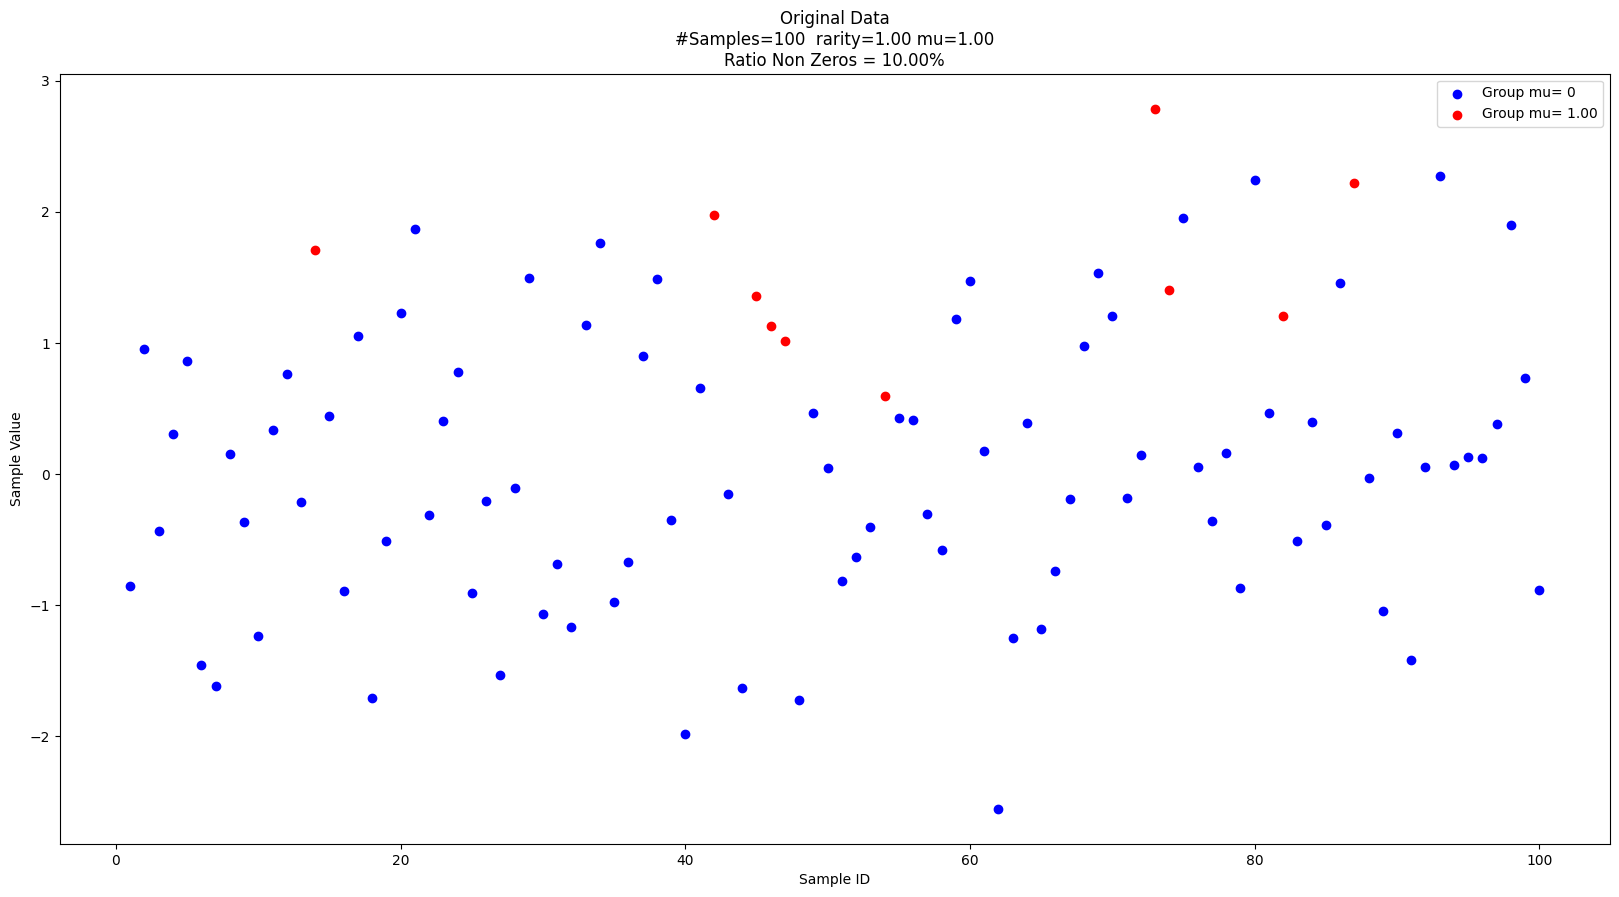

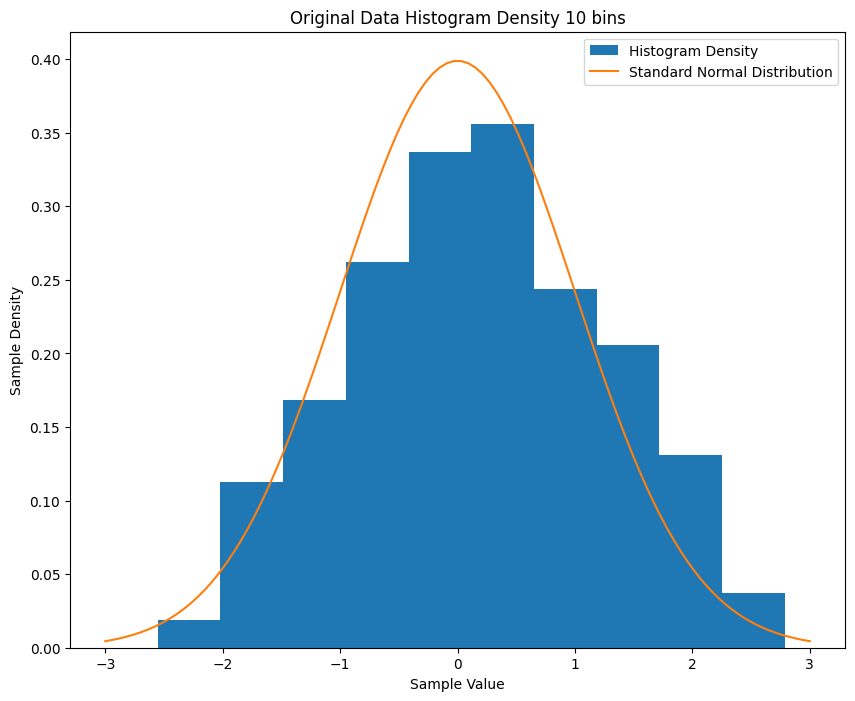

In [113]:
data = DataCreator()
data.original_scatter()
data.histogram()

# Sorting according to P-values

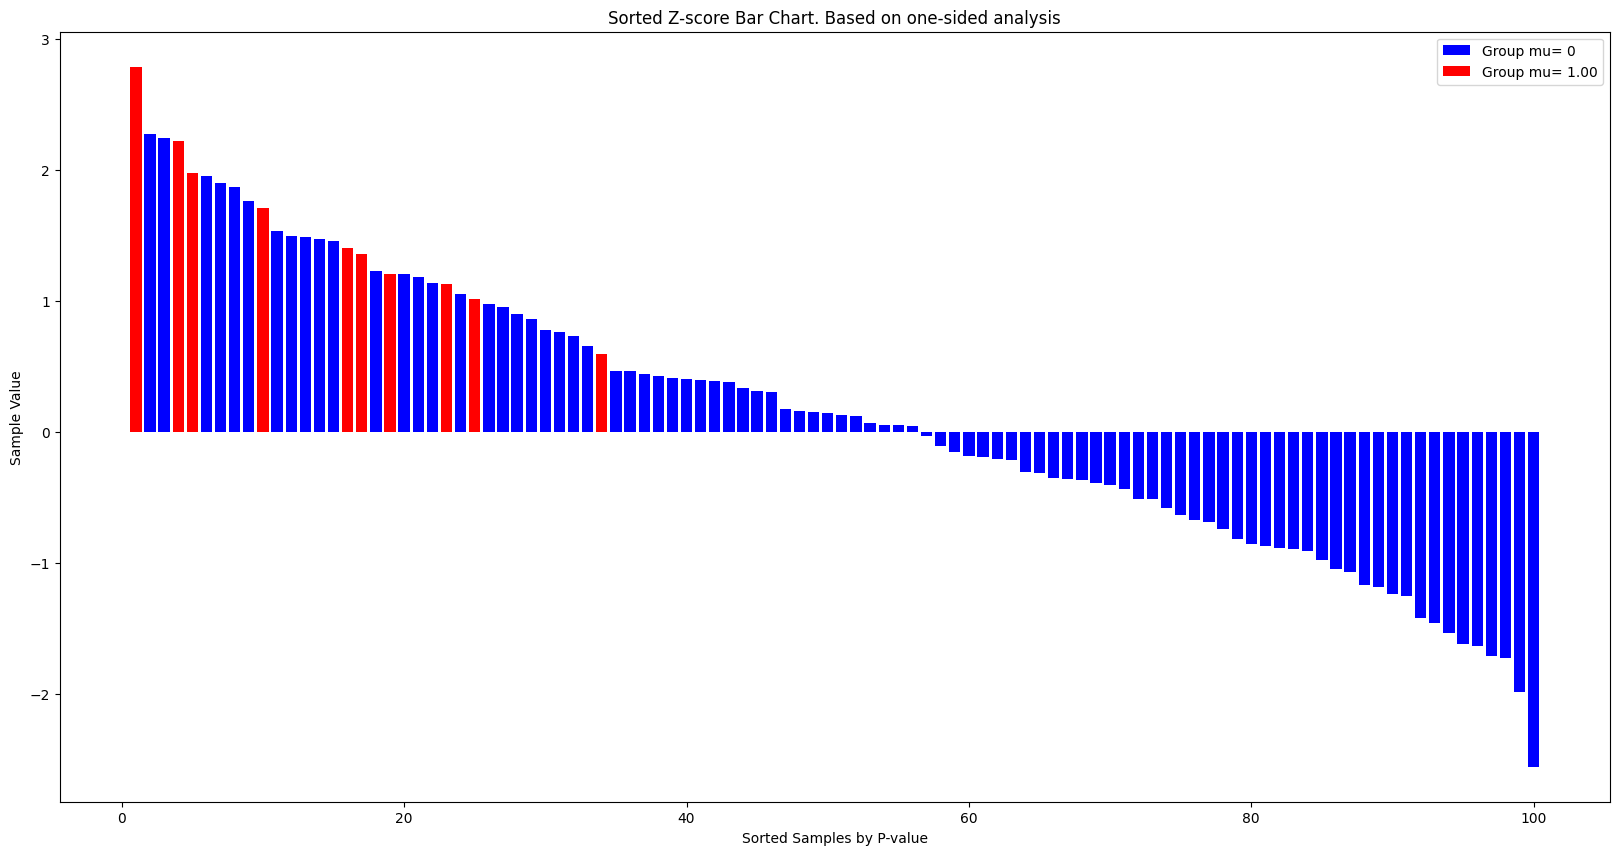

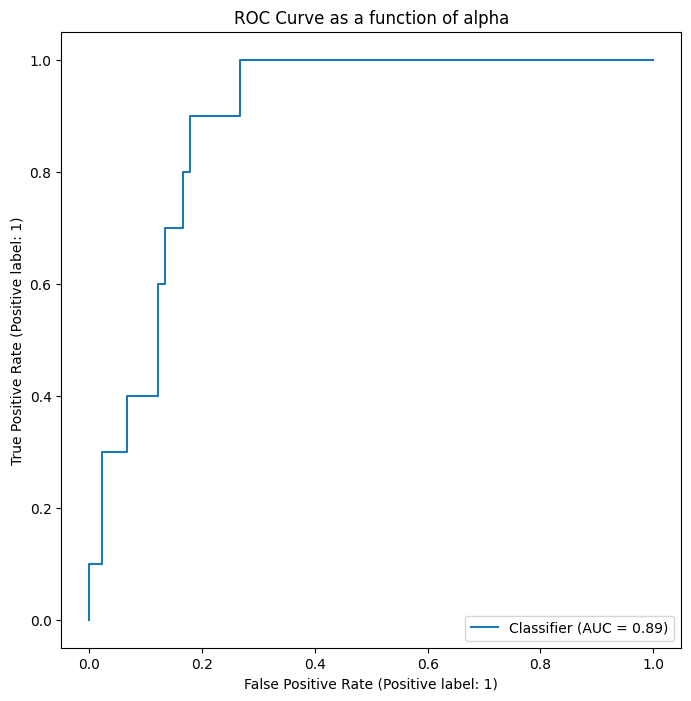

In [114]:
data.sorted_bar_chart()
data.ROC_Curve()

# Rejecting Multi Null Hypothesis

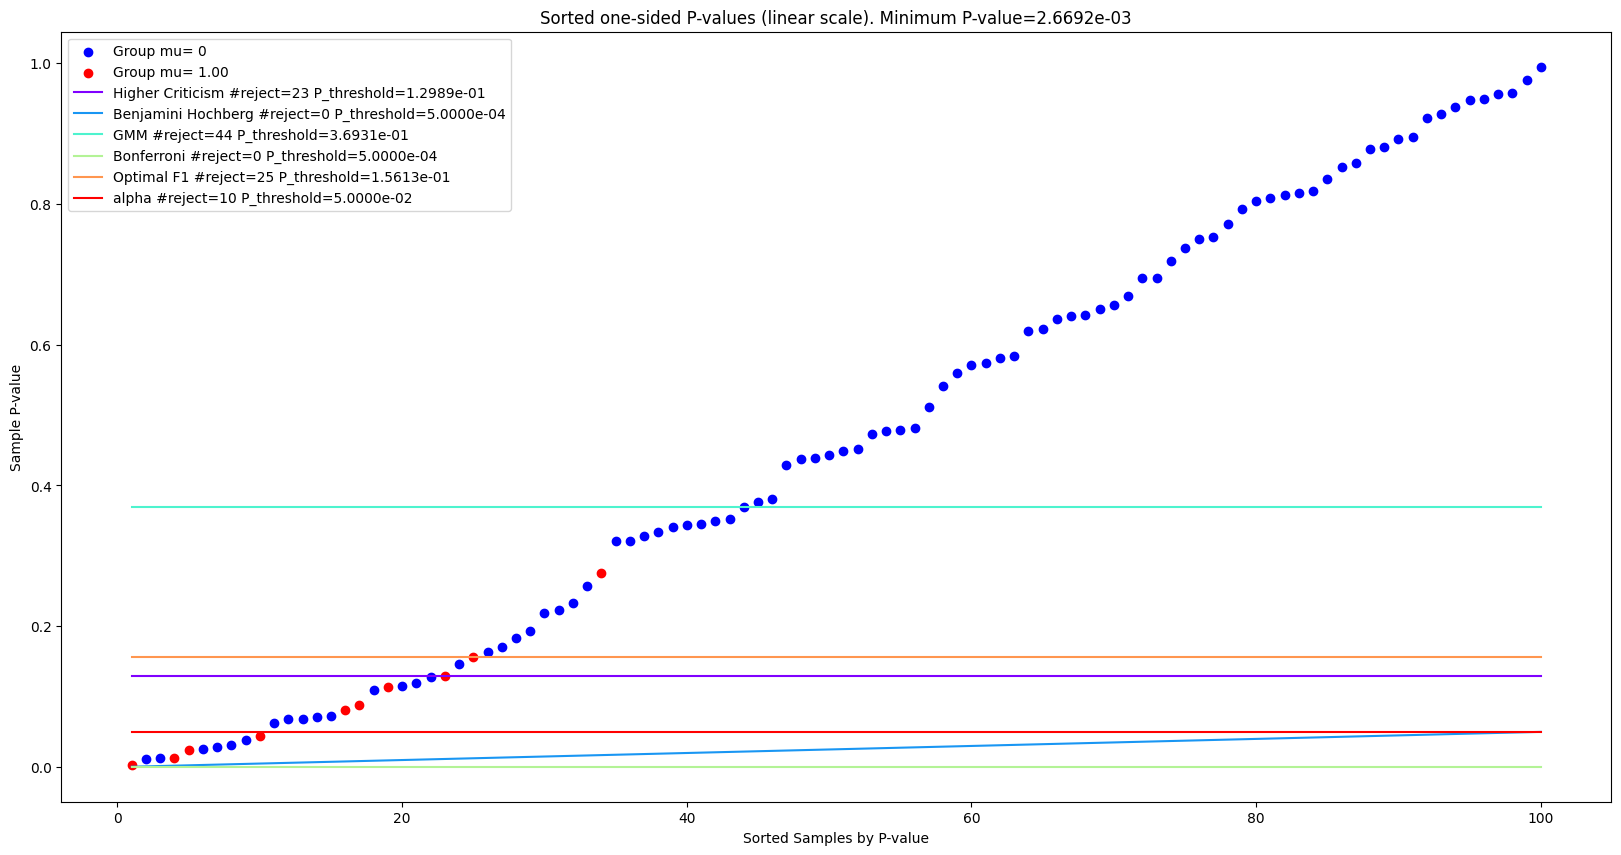

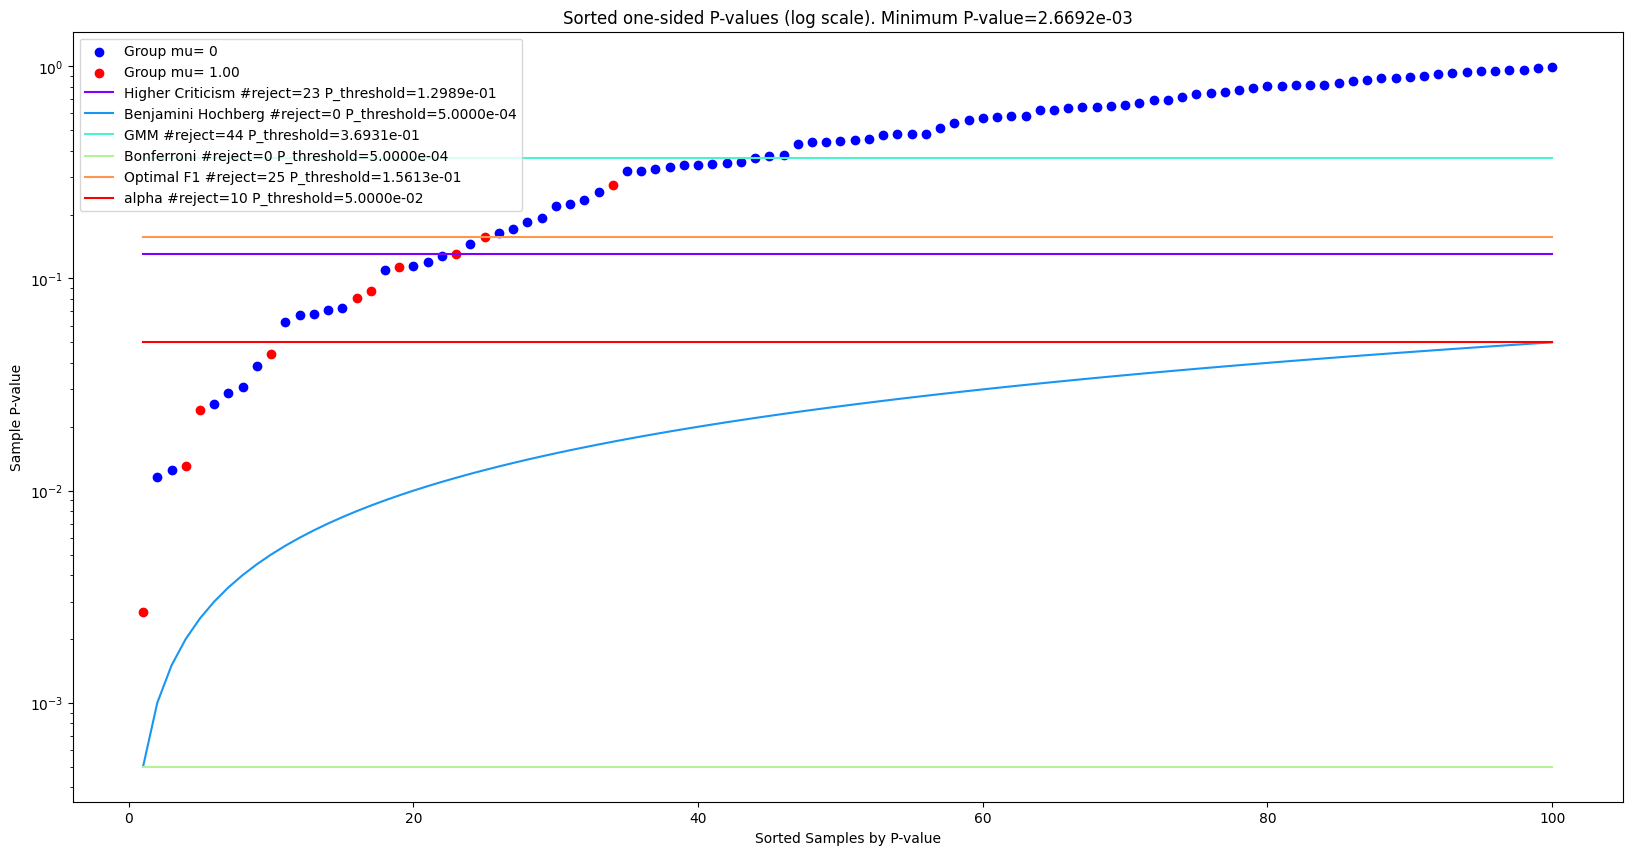

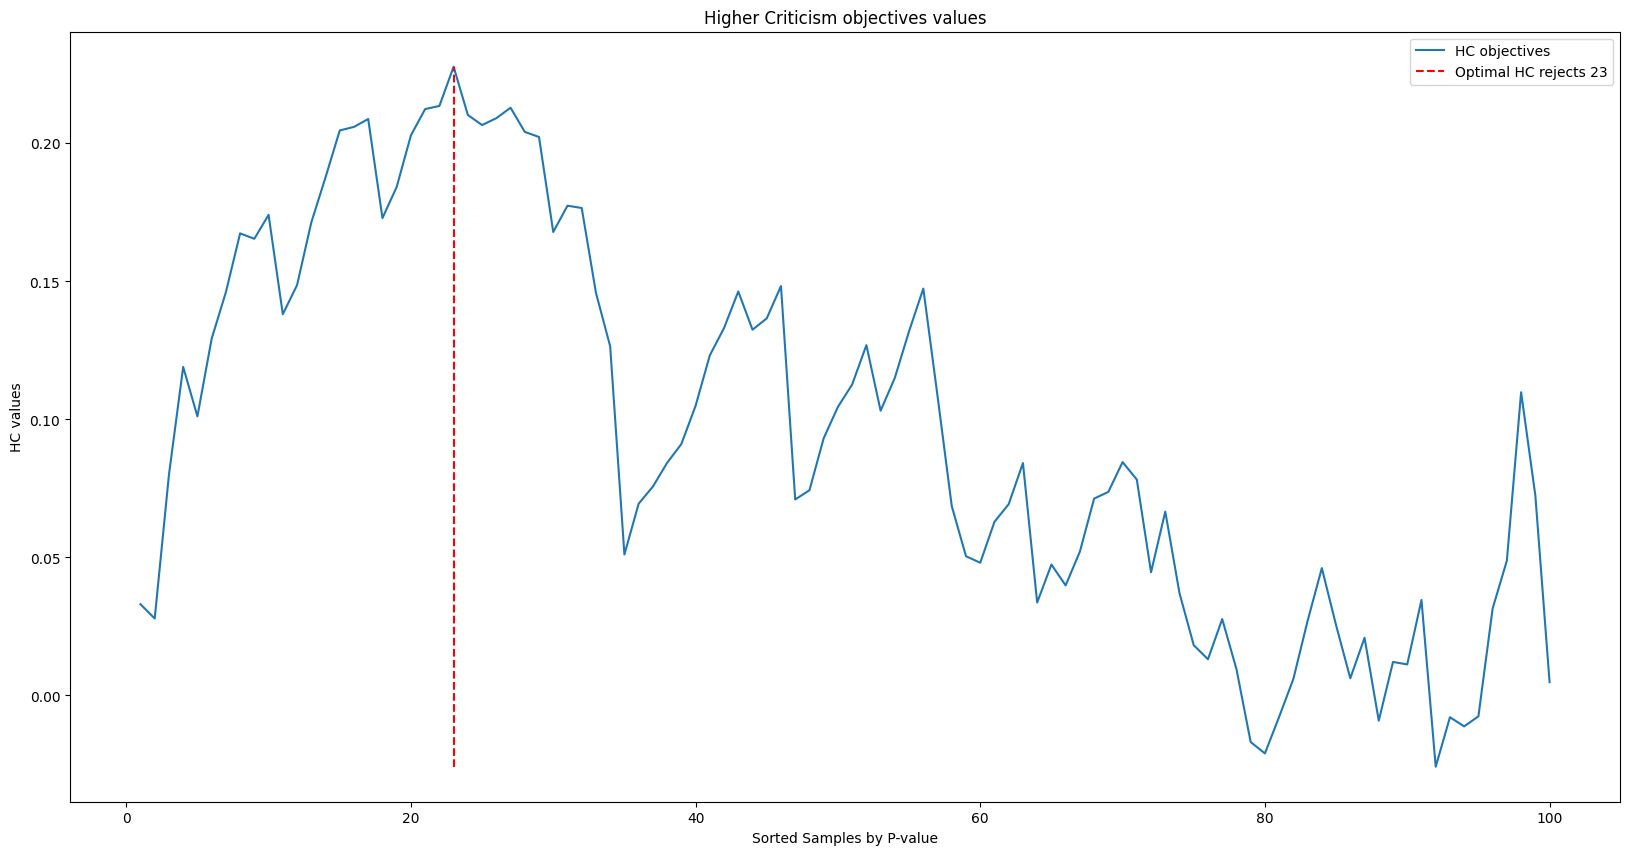

In [115]:
data.p_values_FDR_chart()
data.plot_HC_objectives()

# Classifications

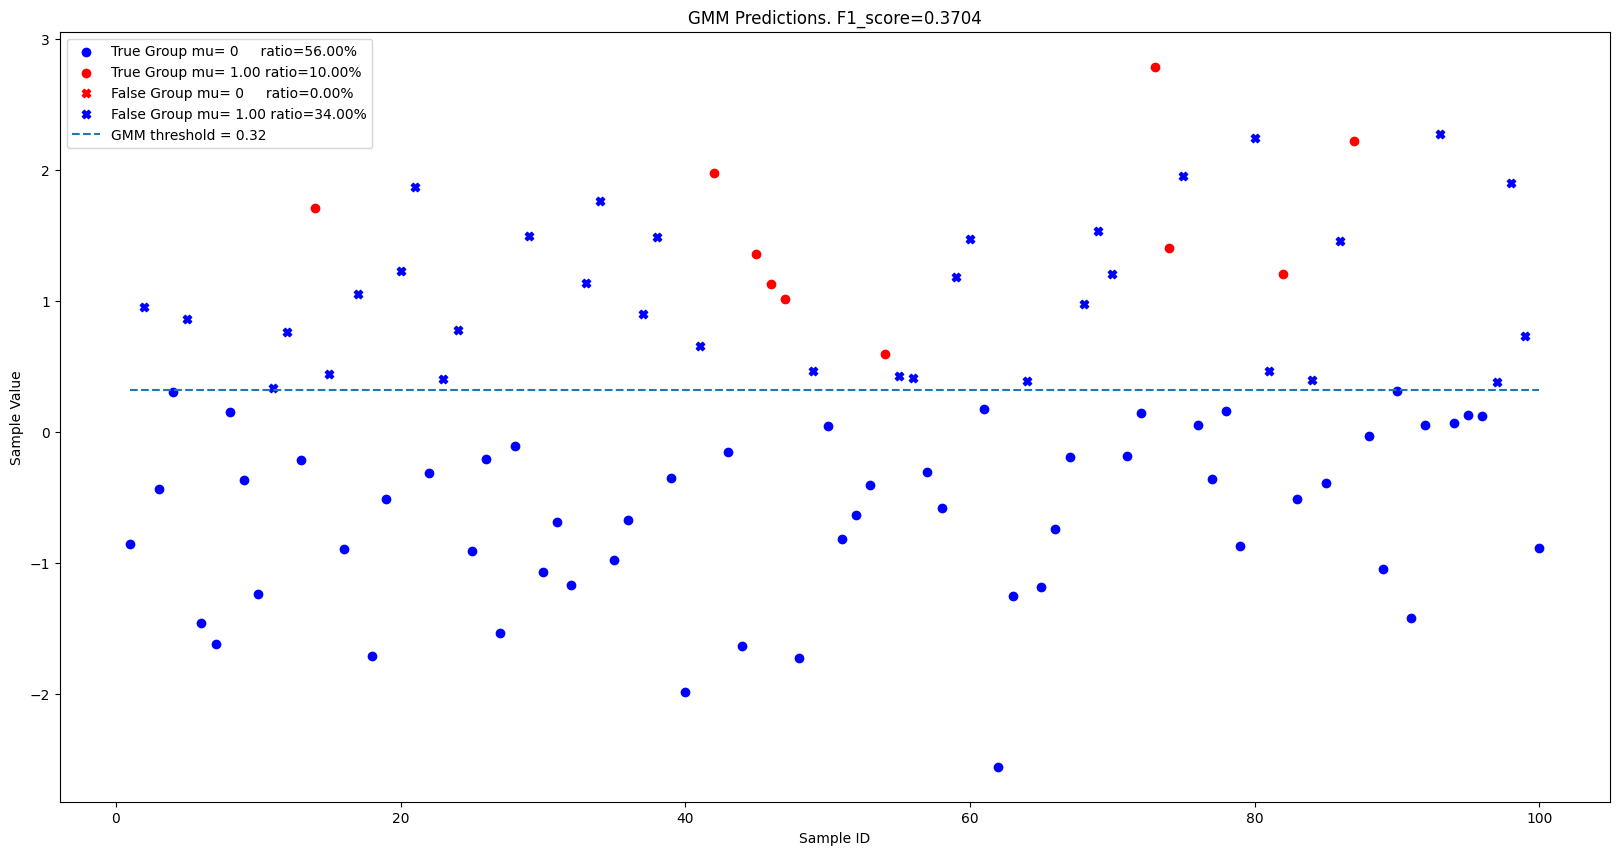

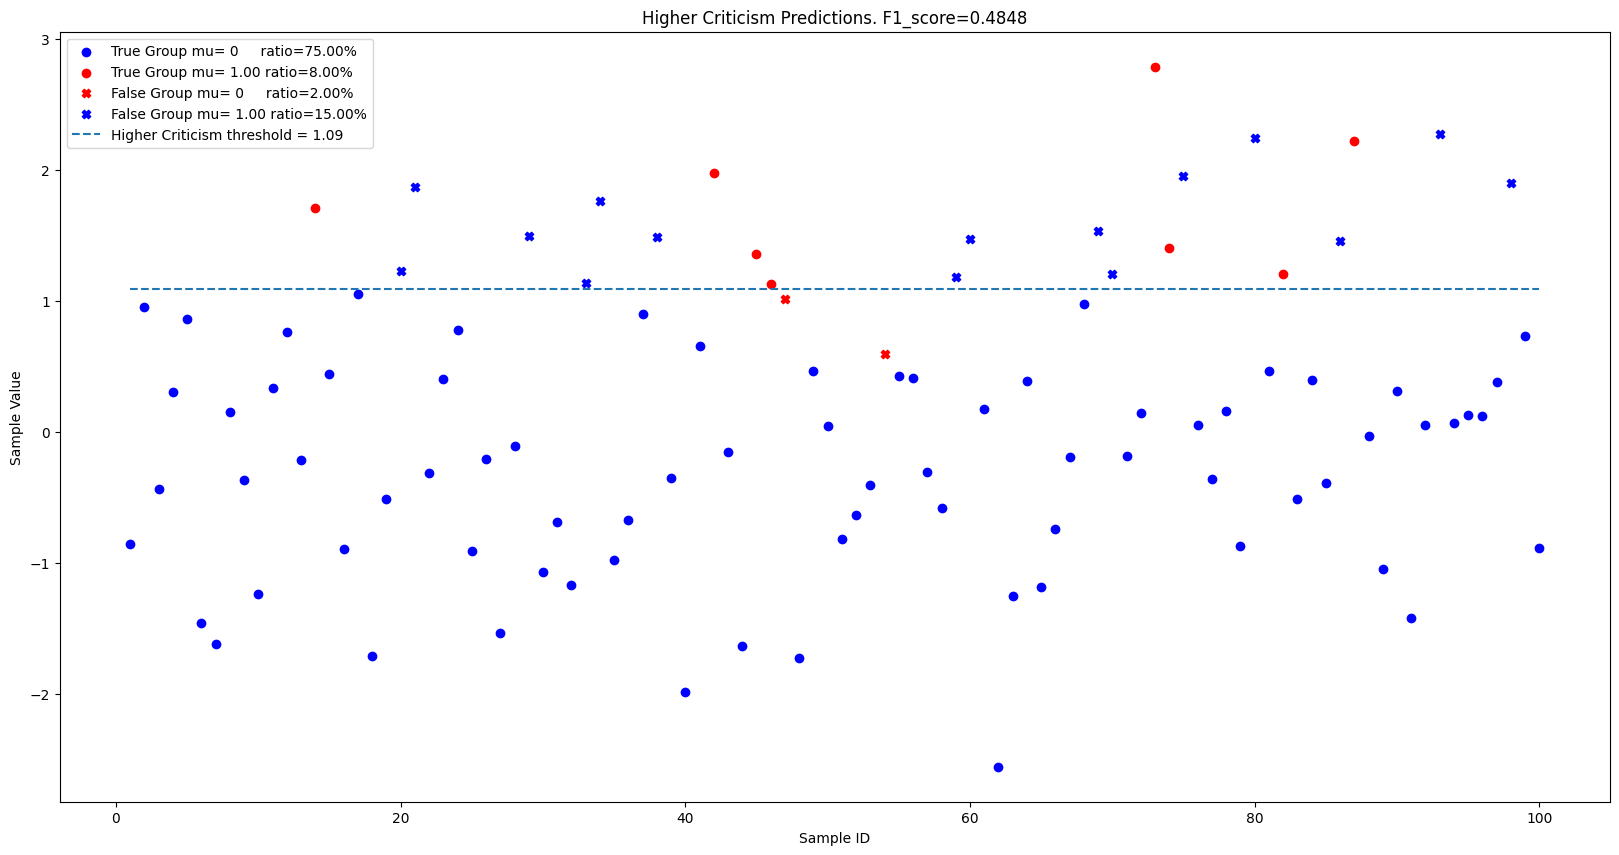

In [116]:
data.gmm_scatter()
data.hc_scatter()

# Optimization of F1-score

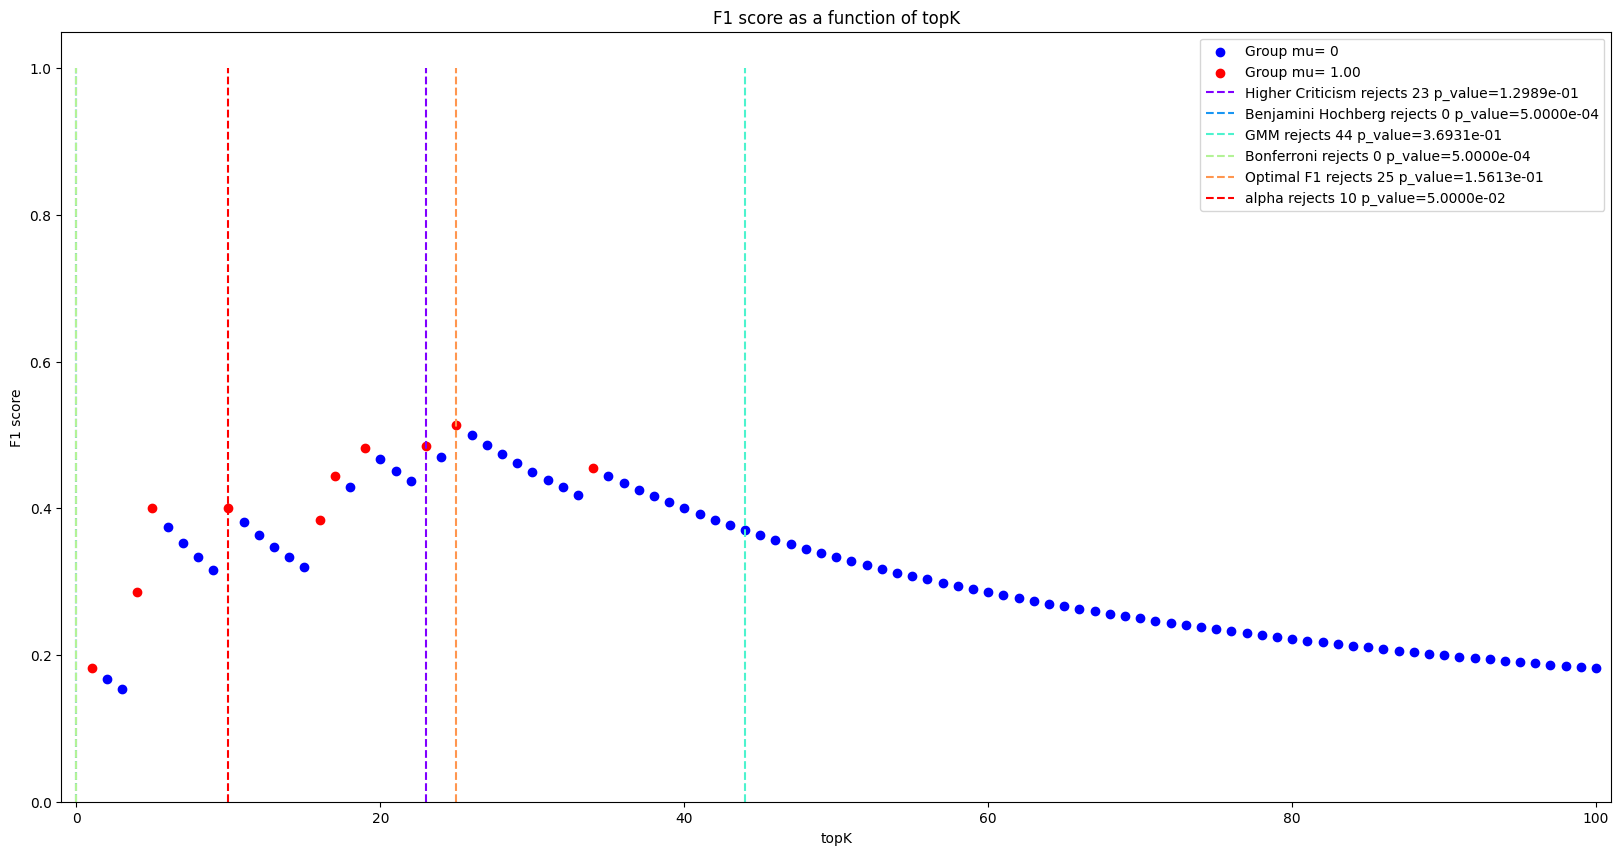

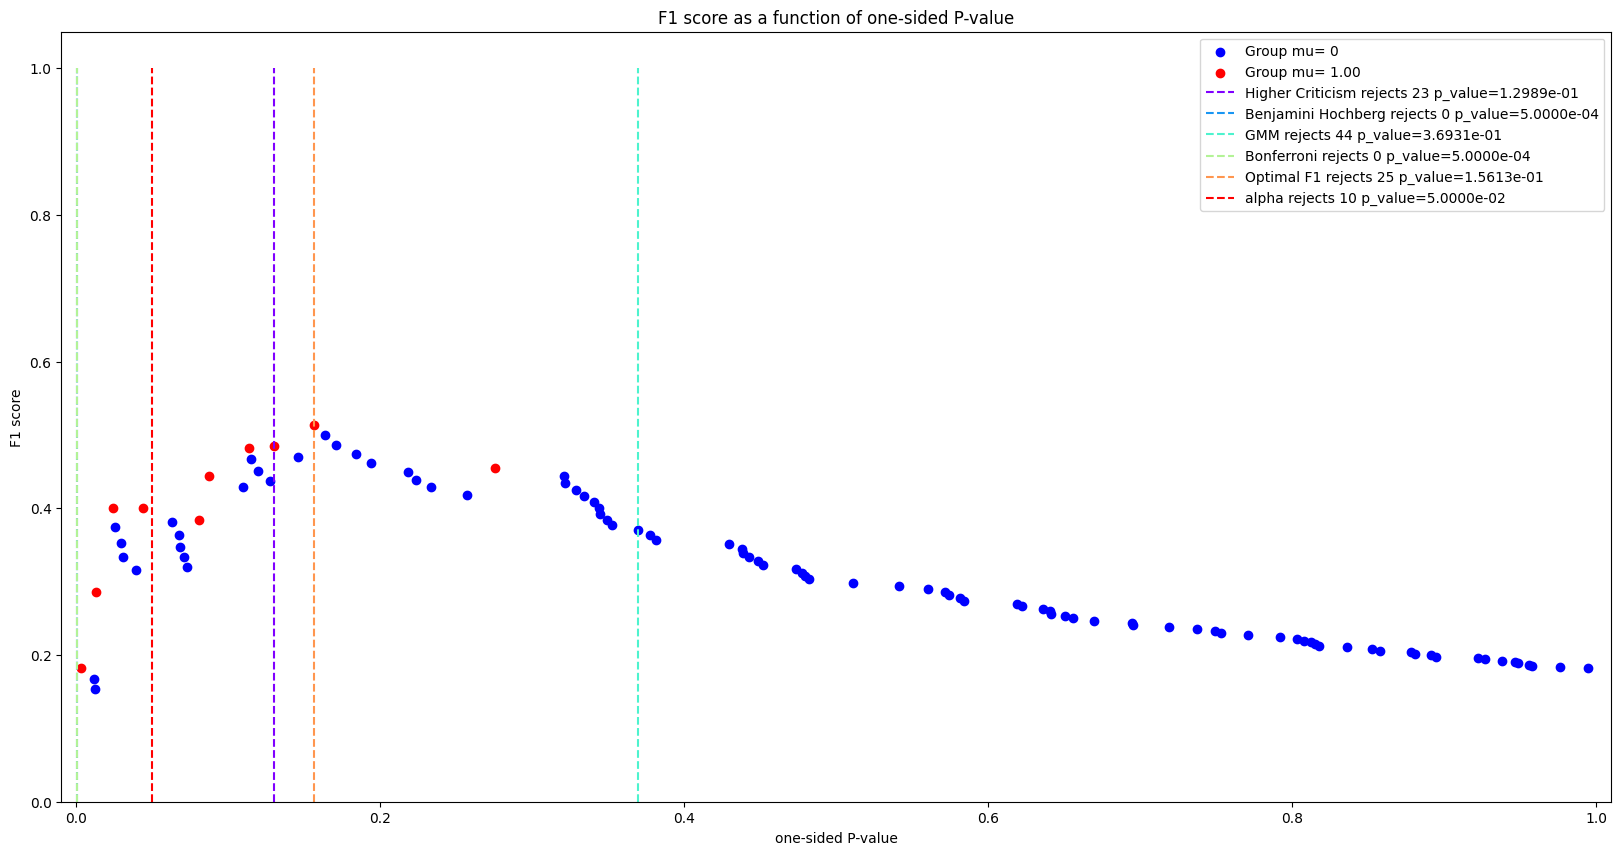

In [117]:
data.plot_f1_score_vs_topK()
data.plot_f1_score_vs_p_value()

In [118]:
N = 10000
rarity = np.arange(1,4.01,0.1)
mu = np.arange(0.5,5.01,0.1)
monte_carlo = 1000
for r in rarity:
    for m in mu:

        for seed in range(monte_carlo):
            data_creator = DataCreator(N=N, rarity=r, mu=m, seed=seed)
            HC_num_rejected = data_creator.higher_criticism.num_rejected
            HC_f1_score = data_creator.f1_score_sorted[HC_num_rejected-1]


KeyboardInterrupt: 